In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time

In [2]:
import matplotlib
myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False   

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
#读取user_pay_count
user_pay_count_df = pd.read_csv("./data/dataset/dataset/user_pay_count.txt", sep='\t', encoding='UTF-8', parse_dates=True, index_col=0)
user_pay_count_df.columns = user_pay_count_df.columns.map(lambda str_date:datetime.datetime.strptime(str_date, "%Y-%m-%d %H:%M:%S"))

In [4]:
#读取开店时间数据
shop_open_date = pd.read_csv("./data/dataset/dataset/shop_open_date.txt", sep='\t', index_col=0, header=None, encoding='UTF-8',parse_dates=[1])

In [60]:
###读取商家信息
shop_infos = pd.read_csv("./data/dataset/dataset/shop_info.txt",
                         encoding='UTF-8',header=None,
                        names=['id','city','loc','per_pay','score',
                               'comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name'], index_col=0, converters={'cate_3_name':np.str})

#dtype={'id':np.int,'city':np.str,'loc':np.int,'per_pay':np.int,'score':np.int,
#                               'comment_cnt':np.int,'shop_level':np.int,'cate_1_name':np.str,'cate_2_name':np.str,'cate_3_name':np.str}

##经查看，只有cate_1_name 是超市便利店的项 cate_3_name 为NULL score为NULL comment_cnt 为NULL 且shop_level <= 1
shop_infos['cate_3_name'] = shop_infos['cate_3_name'].astype(str)

dtype('O')

In [6]:
#读取休假表
calendar = pd.read_csv('./data/dataset/dataset/calendar.txt', sep='\t', encoding='UTF-8', header=None, index_col=0, parse_dates=True)
calendar.index = calendar.index.format()

In [9]:
def getShopPayTimeSeries(shop_id, date_range):
     return user_pay_count_df.ix[shop_id][date_range[0]:(date_range[1] + datetime.timedelta(hours=23))]

In [10]:
def getShopPayTimePeriods(shop_id, date_range, time_range):
    ts = getShopPayTimeSeries(shop_id, date_range)
    period_start = pd.date_range(start=date_range[0], end=date_range[1],freq='D')
    period_end = pd.date_range(start=date_range[0], end=date_range[1],freq='D')
    period_start = period_start + time_range[0];
    period_end = period_end + time_range[1];
    #range(len(period_start))
    #period_start[i]:period_end[i]
    
    periods = None
    for i in range(len(period_start)):
        if i == 0: 
            periods = ts[period_start[i]:period_end[i]]
        else:
            print('%d a'%(i))
            periods = periods.append(ts[period_start[i]:period_end[i]])
            print(periods)
    return periods;

In [26]:
def countShopPayTimePeriods(shop_id, date_range, time_range):
    ts = getShopPayTimeSeries(shop_id, date_range)
    period_start = pd.date_range(start=date_range[0], end=date_range[1],freq='D')
    period_end = pd.date_range(start=date_range[0], end=date_range[1],freq='D')
    period_start = period_start + time_range[0];
    period_end = period_end + time_range[1];
    #range(len(period_start))
    #period_start[i]:period_end[i]
    periods = pd.Series();
    for i in range(len(period_start)):
        count = ts[period_start[i]:period_end[i]].sum()
        periods[period_start[i]] = count;
        #print('%d %s %d a'%(i, period_start[i], count))
    return periods;

In [38]:
def plotShopPayCounts(shop_id, date_range, time_range):
    counts = countShopPayTimePeriods(shop_id, date_range, time_range)
    
    f, (ax) = plt.subplots(1, 1, figsize=(10, 5))
    
    ax.plot(counts.index, counts.values)
    info = shop_infos.ix[shop_id]
    print(type(info.cate_3_name))
    plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
    mean_value = np.mean(counts)
    ax.axhline(y=mean_value, linewidth=1, color='r')
    holiday_counts = choiceCalendarDay(counts, 0)
    #calendar.ix[s.index.strftime('%Y-%m-%d')][1]
    #calendar_filter = calendar.ix[counts.index.strftime('%Y-%m-%d')][1] == 1]
    #print(holiday_counts)
    ax.scatter(holiday_counts.index, holiday_counts.values, c='r')
    #ax.plot(holiday_counts.index, holiday_counts.values, 'r')
    plt.show()
    

In [39]:
#筛选出休息日或者工作日
def choiceCalendarDay(df, t):
    df.index = df.index.strftime('%Y-%m-%d')
    temp = calendar[calendar[1] == t]
    intersection = list(set(df.index.values) & set(temp.index.values))
    result = df[intersection];
    #print(result)
    result = pd.DataFrame(result)
    result.set_index(pd.to_datetime(result.index))
    result=result.sort_index()
    return result

2016-07-19 00:00:00
<class 'str'>


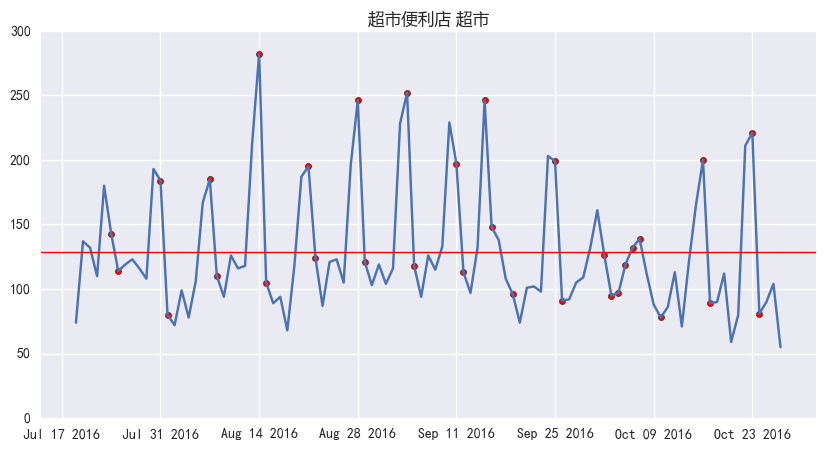

In [91]:
#getShopPayTimePeriods
#id = 56
id = 700
open_time = shop_open_date.loc[id][1];
print(open_time)
start_time = open_time;
end_time = open_time + datetime.timedelta(100)
plotShopPayCounts(id, date_range=[start_time, end_time], time_range=[datetime.timedelta(hours=0), datetime.timedelta(hours=23)])


1

In [137]:
def plotShopPayDayInfos(shop_id, start, count):
    
    info = shop_infos.ix[shop_id]
    
    f, (ax) = plt.subplots(1, 1, figsize=(15, 5))
    plt.title(info.cate_1_name + ' ' + info.cate_2_name + ('' if info.cate_3_name is None else info.cate_3_name), fontproperties=myfont)
    
    for i in range(count):
        start_time = start
        end_time = start_time + datetime.timedelta(1)
        s = getShopPayTimeSeries(id, date_range=[start_time, end_time])
        ax.plot(s.index, s.values, label=('holiday' if calendar.loc[start_time.strftime('%Y-%m-%d')][1] == 0 else 'workday'))
        start = end_time
    
    
    ax.legend()
    plt.show()

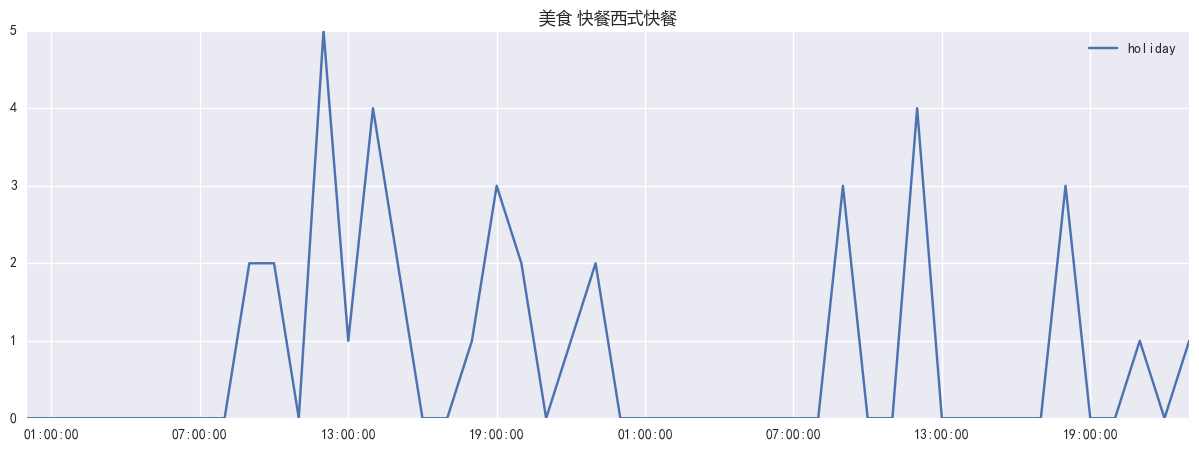

In [143]:
id = 56
open_time = shop_open_date.loc[id][1];
open_time = open_time + datetime.timedelta(6)

plotShopPayDayInfos(id, open_time, 1)

In [144]:

# 
# print(open_time)
# start_time = open_time + datetime.timedelta(8)
# end_time = start_time + datetime.timedelta(1)
# s = getShopPayTimeSeries(id, date_range=[start_time, end_time])

# info = shop_infos.ix[id]
# cate_name = info.cate_1_name + ' ' + info.cate_2_name;
# calendar.index = calendar.index.astype(np.int64)
# title = cate_name + ' ' + ('holiday' if calendar.loc[start_time.value][1] == 0 else 'workday');
# ax = s.plot();
# plt.title(title, fontproperties=myfont)
# plt.show()

pandas.core.series.Series

2015-11-25 01:00:00
2015-11-25 10:00:00 0 a
2015-11-26 10:00:00 53 a
2015-11-27 10:00:00 46 a
2015-11-28 10:00:00 32 a
2015-11-29 10:00:00 9 a
2015-11-30 10:00:00 9 a
2015-12-01 10:00:00 10 a
2015-12-02 10:00:00 0 a


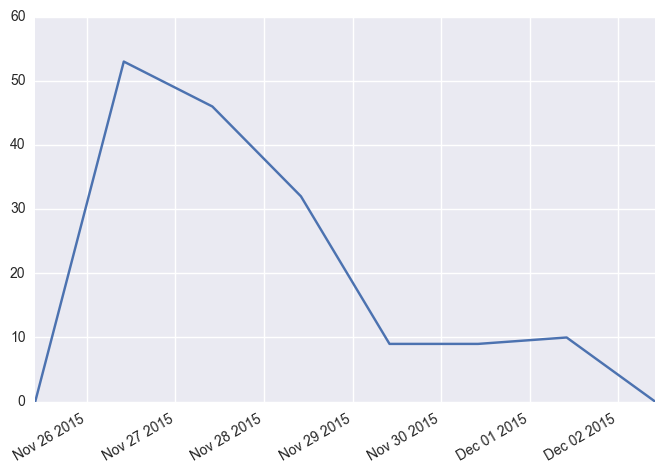

In [15]:
#countShopPayTimePeriods
id = 2
open_time = shop_open_date.loc[id][1];
print(open_time)
start_time = open_time;
end_time = open_time + datetime.timedelta(7)
s = countShopPayTimePeriods(id, date_range=[start_time, end_time], time_range=[datetime.timedelta(hours=9), datetime.timedelta(hours=14)])
s.plot()
plt.show()

In [13]:
shop_infos['cate_1_name'].value_counts()

美食          1415
超市便利店        579
休闲娱乐           2
医疗健康           2
美发/美容/美甲       1
购物             1
Name: cate_1_name, dtype: int64

In [14]:
shop_infos[shop_infos['cate_1_name'] == '超市便利店']

,id,city,loc,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
1,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,NaN
3,4,天津,380,18,NaN,NaN,1,超市便利店,超市,NaN
8,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,NaN
9,10,孝感,98,10,NaN,NaN,0,超市便利店,超市,NaN
14,15,西安,101,19,NaN,NaN,0,超市便利店,超市,NaN
22,23,青岛,645,3,3.0,0.0,1,超市便利店,便利店,NaN
30,31,北京,571,18,NaN,NaN,1,超市便利店,超市,NaN
31,32,杭州,789,2,4.0,0.0,1,超市便利店,便利店,NaN
32,33,成都,1159,20,NaN,NaN,1,超市便利店,超市,NaN
34,35,东莞,296,18,2.0,0.0,0,超市便利店,超市,NaN


In [44]:
shop_infos["city"].value_counts().shape

(122,)

In [ ]:
def getShopPayCompareWeekSeries(shop_id)

In [ ]:
def getShopOpenTime(shop_id)
    return shop_open_time_index[shop_id]